## 快手活跃用户预测

项目背景：  
&emsp;&emsp;快手app用户活跃预测。基于脱敏和采样后的数据信息，预测未来一段时间活跃的用户。
数据时间范围是从第1天到第30天。将'未来7天（第31天至第37天）内使用app(启动即使用)的用户定义为"活跃用户"，需要从过去用户数据中预测这部分用户

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
from sklearn.feature_extraction import FeatureHasher
import warnings

warnings.filterwarnings('ignore')

In [2]:
user_register = pd.read_csv(
    r'/Users/panzixu_mac/Downloads/数据分析/八大项目实战/资料/慕课数据分析中级项目数据/第七章/APP用户活跃度/user_register_log.txt',
    sep='\t', names=['user_id', 'register_day', 'register_type', 'device_type'],
    dtype={'register_type': 'str', 'device_type': 'str'})
app_launch = pd.read_csv(
    r'/Users/panzixu_mac/Downloads/数据分析/八大项目实战/资料/慕课数据分析中级项目数据/第七章/APP用户活跃度/app_launch_log.txt',
    sep='\t', names=['user_id', 'launch_day'])
user_activity = pd.read_csv(
    r'/Users/panzixu_mac/Downloads/数据分析/八大项目实战/资料/慕课数据分析中级项目数据/第七章/APP用户活跃度/user_activity_log.txt',
    sep='\t', names=['user_id', 'act_day', 'page', 'video_id', 'author_id', 'action_type'] )
video_create = pd.read_csv(
    r'/Users/panzixu_mac/Downloads/数据分析/八大项目实战/资料/慕课数据分析中级项目数据/第七章/APP用户活跃度/video_create_log.txt',
    sep='\t', names=['user_id', 'create_day'])


### 数据清洗，可视化探索

In [3]:
# 检测数据缺失，数据类型
user_register.info()
app_launch.info()
user_activity.info()
video_create.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51709 entries, 0 to 51708
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        51709 non-null  int64 
 1   register_day   51709 non-null  int64 
 2   register_type  51709 non-null  object
 3   device_type    51709 non-null  object
dtypes: int64(2), object(2)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251943 entries, 0 to 251942
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   user_id     251943 non-null  int64
 1   launch_day  251943 non-null  int64
dtypes: int64(2)
memory usage: 3.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20607228 entries, 0 to 20607227
Data columns (total 6 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   act_day      int64
 2   page         int64
 3   video_id     int64
 4   author_id    

In [4]:
# 探查单个用户有无重复记录，注册数据异常
user_register.duplicated(subset='user_id').any()

False

In [5]:
# 确认只有一条记录每天登录用户
app_launch.duplicated().any()

False

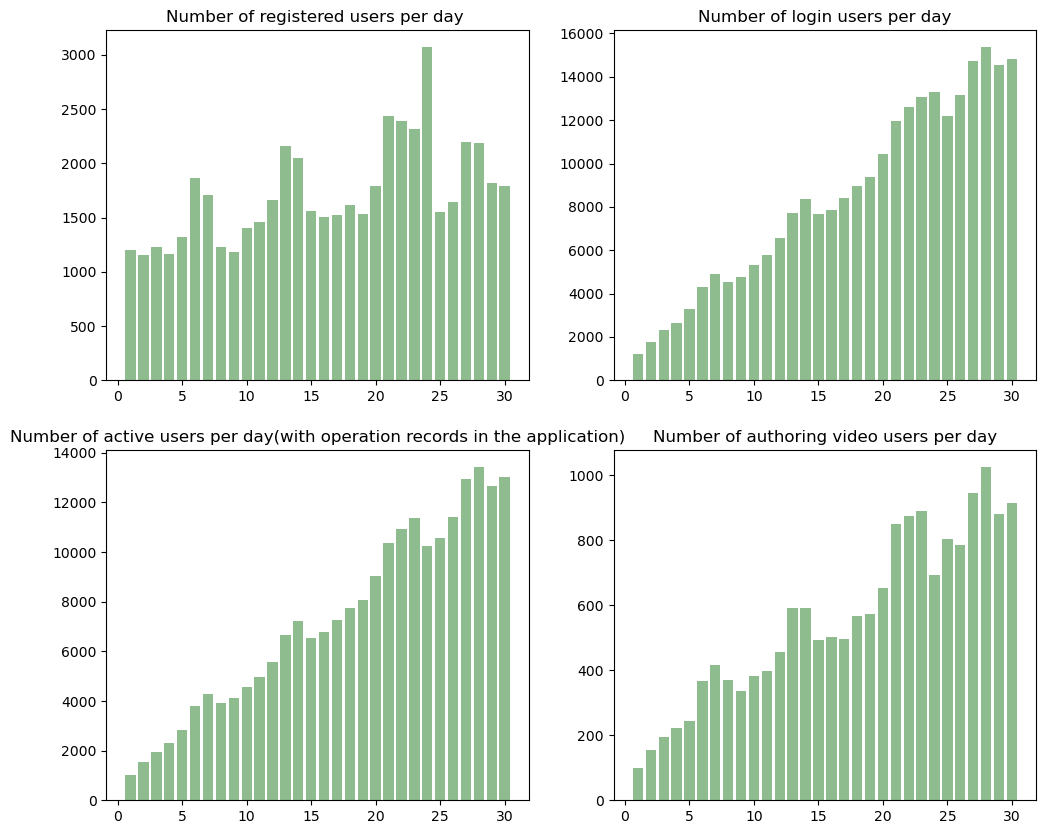

In [6]:
# 可视化探索 设置网格图
plt.figure(figsize=(12, 10))
sns.set_style()
plt.subplot(2, 2, 1)
plt.bar(user_register['register_day'].value_counts().index, user_register['register_day'].value_counts().values,
        color='darkseagreen')
plt.title('Number of registered users per day ')
plt.subplot(2, 2, 2)
plt.bar(app_launch['launch_day'].value_counts().index, app_launch['launch_day'].value_counts().values,
        color='darkseagreen')
plt.title('Number of login users per day')
plt.subplot(2, 2, 3)
plt.bar(user_activity.groupby('act_day').nunique()['user_id'].index,
        user_activity.groupby('act_day').nunique()['user_id'].values, color='darkseagreen')
plt.title('Number of active users per day(with operation records in the application)')
plt.subplot(2, 2, 4)
plt.bar(video_create.groupby('create_day').nunique()['user_id'].index,
        video_create.groupby('create_day').nunique()['user_id'].values, color='darkseagreen')
plt.title('Number of authoring video users per day')
plt.show()


分析说明：用户行为具有周期性，周期大概为7天，整体数量呈上升趋势。从每天注册用户数量中可以看到，第24天注册数量偏高，
在对每天在app中有操作记录、创作视频的用户数量统计中发现，第24天并无明显下降趋势，故排出作弊导量的可能。

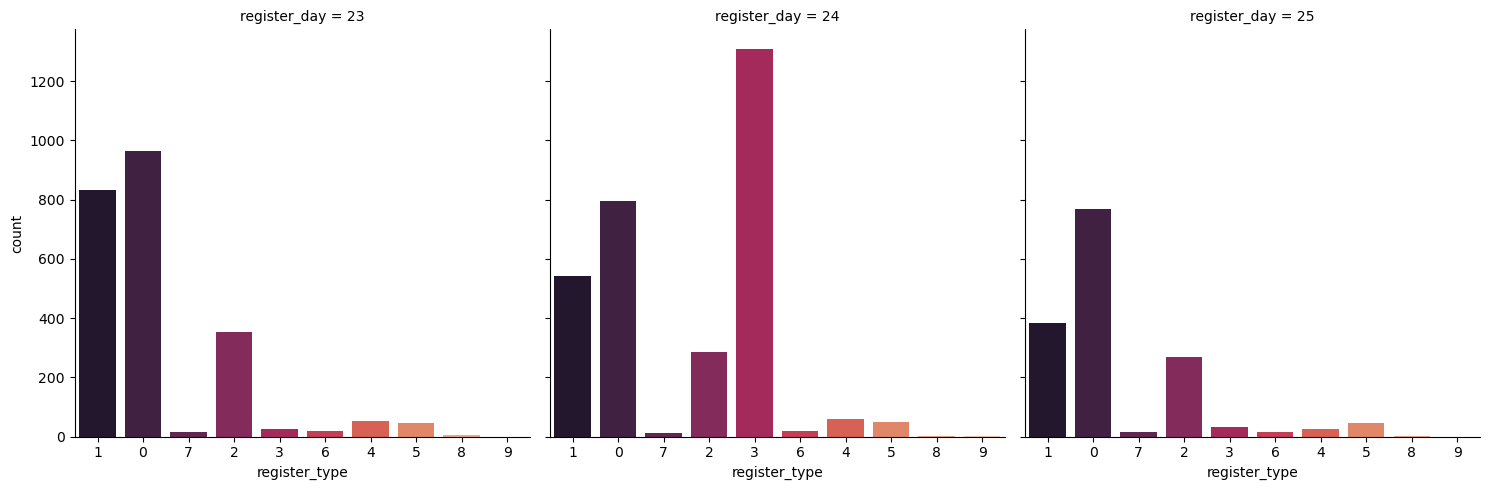

In [7]:
# 探查第24天用户来源渠道的分布，与其后几天对比
sns.catplot(data=user_register.loc[user_register['register_day'].isin([23, 24, 25]), :], x='register_type',
            kind='count',
            col='register_day', palette="rocket")
plt.show()

24号在数字3对应的渠道做推广，带来了新增用户

### 特征工程

用滑窗法扩充数据集，并为分类问题打上标签。滑窗法可以扩充训练集。

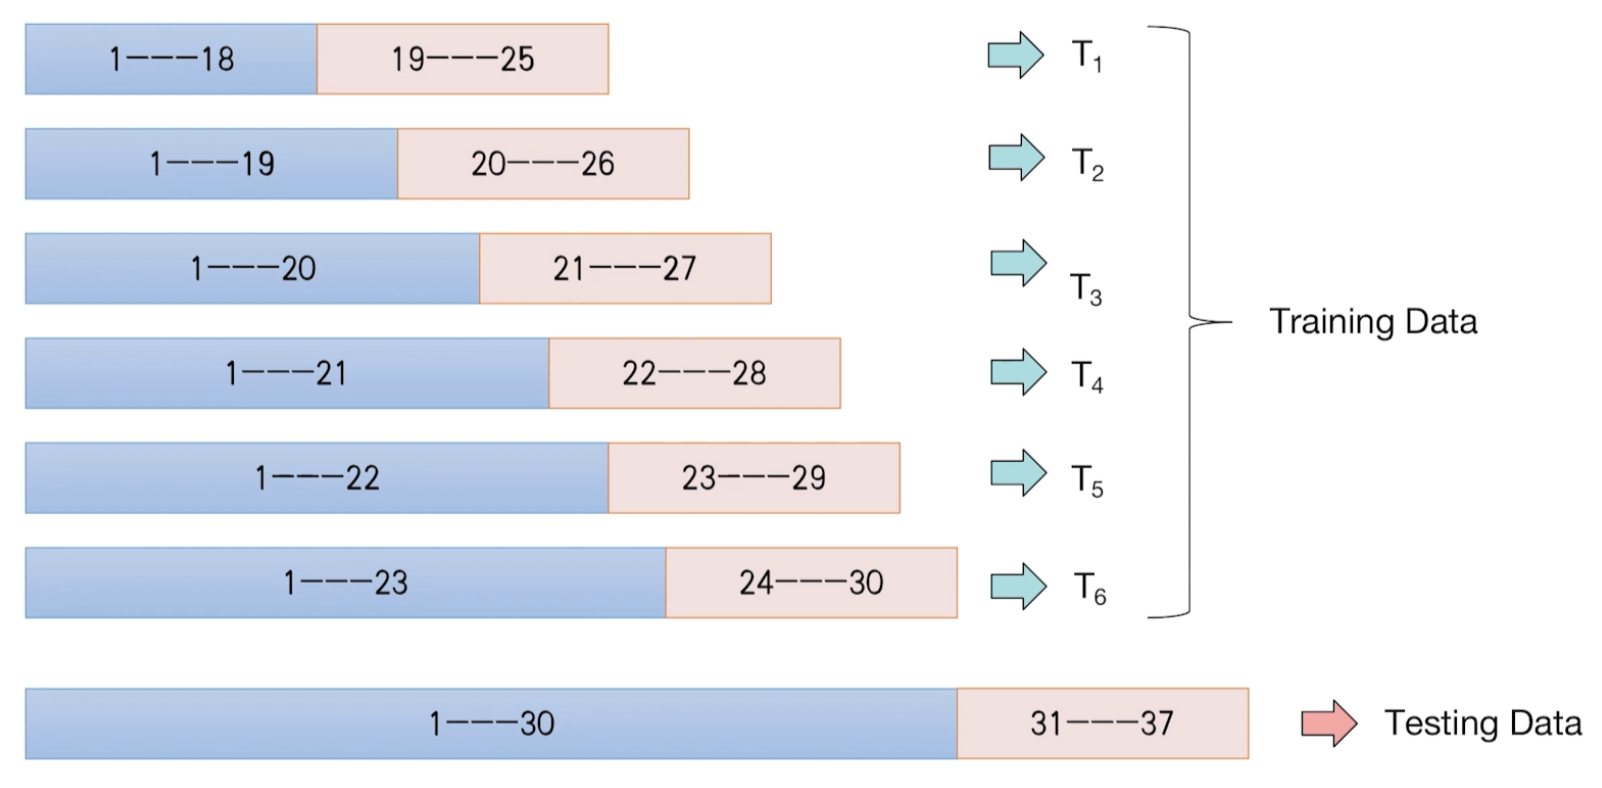

In [8]:
from IPython.display import Image
Image(filename =r'/Users/panzixu_mac/Downloads/滑窗法扩充数据集.png',)

注册信息可以提取到的特征有：
用户注册日距离最近预测日天数
注册来源渠道one_hot编码
设备类型离散值比较多，采用sklearn.feature_extraction.FeatureHasher处理，保留10个特征，使用python3.7.6环境运行，更高版本会报错

In [9]:
def register_feature(data):
    data['jujin_register_day'] = max(data['register_day']) - data['register_day']  # 最大注册日期即是预测日期前一天
    data = pd.get_dummies(data, columns=['register_type'], drop_first=True)
    fea_hs = FeatureHasher(n_features=10, input_type='string')
    hasherd = fea_hs.fit_transform(data['device_type'])
    hash_data = pd.DataFrame(hasherd.toarray(), columns=['device_type_{0}'.format(i) for i in range(10)])
    data = pd.concat([data, hash_data], axis=1, ignore_index=False)
    data.drop(['register_day', 'device_type'], axis=1, inplace=True)
    return data

In [10]:
def video_feature(data):
    data_temp_1 = data.drop_duplicates(['user_id', 'create_day']).sort_values(by=['user_id', 'create_day'])
    data_temp_1['next_day'] = data_temp_1.groupby('user_id')['create_day'].shift(-1)
    # 发布时间间隔
    data_temp_1['create_gap'] = data_temp_1['next_day'] - data_temp_1['create_day']
    # 剔除无时间间隔空行
    data_temp_1.dropna(axis=0, inplace=True)
    # 时间间隔方差/均值
    data_temp_1 = data_temp_1[['user_id', 'create_gap']].groupby('user_id').agg(['mean', np.var]).droplevel(level=0,
                                                                                                            axis=1).reset_index().rename(
        {'mean': 'create_gap_mean',
         'var': 'create_gap_var'}, axis=1).fillna(0)
    # 是否连续发布视频到结束
    # 用户最后一天发布视频
    temp = data.groupby('user_id').max().reset_index()
    temp_users = temp.loc[temp['create_day'] == max(temp['create_day']), 'user_id']
    data_temp_1['always_create_atlast'] = data_temp_1.loc[data_temp_1['create_gap_mean'] == 1, 'user_id'].isin(
        temp_users)
    data_temp_1['always_create_atlast'] = data_temp_1['always_create_atlast'].map({True: 1, False: 0}).fillna(0)
    # 发布视频计数,用户发布视频日期的平均/最大/最小/平均/方差/丰度/偏度
    data_temp = data.groupby('user_id')['create_day'].agg(['count', 'max', 'min', 'mean', np.var, stats.skew,
                                                           stats.kurtosis]).reset_index().rename(
        {'count': 'video_create_num', 'var': 'video_create_var', 'skew': 'video_create_skew',
         'kurtosis': 'video_create_kurtosis'}, axis=1)
    # 最大发布日期距今
    data_temp['jujin_video_red_create_max'] = max(data_temp['max']) - data_temp['max']
    # 最小发布日期距今
    data_temp['jujin_video_red_create_min'] = max(data_temp['max']) - data_temp['min']
    # 平均发布日期距今
    data_temp['jujin_video_red_create_mean'] = max(data_temp['max']) - data_temp['mean']
    # 最大发布日期-最小发布日期
    data_temp['video_max_red_min'] = data_temp['max'] - data_temp['min']
    # 最后一天是否发布
    data_temp['video_last_day'] = pd.Series(data_temp['max'] == max(data_temp['max'])).map({True: 1, False: 0})
    # 一天最多发布数量
    data['max_create_in_oneday'] = 0
    temp = pd.pivot_table(data, index=['user_id', 'create_day'], values='max_create_in_oneday',
                          aggfunc='count').reset_index()
    data_temp_2 = pd.DataFrame(temp.groupby(['user_id'])['max_create_in_oneday'].max().reset_index())

    data = pd.merge(data_temp_1, data_temp, how='outer', left_on='user_id', right_on='user_id')
    data = pd.merge(data, data_temp_2, how='outer', left_on='user_id', right_on='user_id')
    data.drop(['max', 'min', 'mean'], axis=1, inplace=True)
    return data


In [11]:
def launch_feature(data):
    # 登录率
    data_temp_1 = data.groupby('user_id')['launch_day'].agg(['count', 'mean', 'max', 'min', np.var, stats.skew,
                                                             stats.kurtosis]).reset_index().rename(
        {'var': 'launch_var', 'skew': 'launch_skew', 'kurtosis': 'launch_kurtosis'}, axis=1)
    distance = max(data['launch_day']) - min(data['launch_day'])
    data_temp_1['launch_ratio'] = data_temp_1['count'] / distance
    # 登录最大、最小时间差
    data_temp_1['max_red_min_launch'] = data_temp_1['max'] - data_temp_1['min']
    # 最大、最小、平均 距今多少天
    data_temp_1['jujin_launch_max'] = max(data['launch_day']) - data_temp_1['max']
    data_temp_1['jujin_launch_min'] = max(data['launch_day']) - data_temp_1['min']
    data_temp_1['jujin_launch_mean'] = max(data['launch_day']) - data_temp_1['mean']
    # 最后一天是否登录
    data_temp_1['launch_lastday'] = pd.Series(data_temp_1['max'] == max(data['launch_day'])).map({True: 1, False: 0})
    # 登录时间间隔
    data_temp_2 = data.drop_duplicates().sort_values(by=['user_id', 'launch_day'])
    data_temp_2['next_lunch_day'] = data_temp_2.groupby('user_id')['launch_day'].shift(-1)
    data_temp_2['launch_gap'] = data_temp_2['next_lunch_day'] - data_temp_2['launch_day']
    # 剔除无时间间隔空行
    data_temp_2.dropna(axis=0, inplace=True)
    # 时间间隔方差/均值/最大值
    data_temp_2 = data_temp_2[['user_id', 'launch_gap']].groupby('user_id').agg(['mean', np.var, 'max']).droplevel(
        level=0, axis=1).reset_index().rename(
        {'mean': 'launch_gap_mean', 'var': 'launch_gap_var', 'max': 'launch_gap_max'}, axis=1).fillna(0)
    # 是否连续登录到结束
    # 用户最后一天登录
    temp = data.groupby('user_id').max().reset_index()
    temp_users = temp.loc[temp['launch_day'] == max(temp['launch_day']), 'user_id']
    data_temp_2['always_launch_atlast'] = data_temp_2.loc[data_temp_2['launch_gap_mean'] == 1, 'user_id'].isin(
        temp_users)
    data_temp_2['always_launch_atlast'] = data_temp_2['always_launch_atlast'].map({True: 1, False: 0}).fillna(0)
    data = pd.merge(data_temp_1, data_temp_2, how='outer', left_on='user_id', right_on='user_id')
    data.drop(['count', 'mean', 'max', 'min'], axis=1, inplace=True)
    return data


In [12]:
def activity_feature(data):
    # 活动计数
    data_temp_1 = data.groupby('user_id')['act_day'].agg(['count', 'max', 'min', 'mean', np.var, stats.skew,
                                                          stats.kurtosis]).reset_index().rename(
        {'count': 'act_count', 'var': 'act_var', 'skew': 'act_skew',
         'kurtosis': 'act_kurtosis'}, axis=1)
    # 最大活动日期距今
    data_temp_1['jujin_act_max'] = max(data_temp_1['max']) - data_temp_1['max']
    # 最小活动日期距今
    data_temp_1['jujin_act_min'] = max(data_temp_1['max']) - data_temp_1['min']
    # 平均活动日期距今
    data_temp_1['jujin_act_mean'] = max(data_temp_1['max']) - data_temp_1['mean']
    # 最大减最小
    data_temp_1['act_max_red_min'] = data_temp_1['max'] - data_temp_1['min']
    # 最后一天是否有活动
    data_temp_1['act_last_day'] = pd.Series(data_temp_1['max'] == max(data_temp_1['max'])).map({True: 1, False: 0})

    # 观看自己计数
    data_temp_2 = data.loc[data['user_id'] == data['author_id'], ['user_id', 'page']].groupby(
        'user_id').count().reset_index().rename({'page': 'act_self_count'}, axis=1)
    # act计数/率
    data_temp_3 = pd.DataFrame(data_temp_1.loc[:, 'user_id'])
    temp = data.loc[:, ['user_id', 'action_type', 'act_day']].groupby(
        ['user_id', 'action_type']).count().reset_index().rename({'act_day': 'action_count'}, axis=1)
    for i in range(6):
        feature_name = 'action_' + str(i) + '_count'
        action_temp = temp.loc[temp['action_type'] == i, ['user_id', 'action_count']].rename(
            {'action_count': feature_name}, axis=1)
        data_temp_3 = pd.merge(data_temp_3, action_temp, on='user_id', how='left', )
  
    data_temp_3['action_all'] = (
            data_temp_3['action_0_count'] + data_temp_3['action_1_count'] + data_temp_3['action_2_count']
            + data_temp_3['action_3_count'] + data_temp_3['action_4_count'] + data_temp_3['action_5_count']).replace(0,
                                                                                                                     1)
    for i in range(6):
        feature_name = 'action_' + str(i) + '_count'
        feature_name_1 = 'action_' + str(i) + '_ratio'
        data_temp_3[feature_name_1] = data_temp_3[feature_name] / data_temp_3['action_all']

    # page 的 计数/率
    temp = data.loc[:, ['user_id', 'page', 'act_day']].groupby(
        ['user_id', 'page']).count().reset_index().rename({'act_day': 'page_count'}, axis=1)
    for i in range(6):
        feature_name = 'page_' + str(i) + '_count'
        action_temp = temp.loc[temp['page'] == i, ['user_id', 'page_count']].rename(
            {'page_count': feature_name}, axis=1)
        data_temp_3 = pd.merge(data_temp_3, action_temp, on='user_id', how='left', )
    data_temp_3.fillna(0, inplace=True)
    data_temp_3['page_all'] = (
            data_temp_3['page_0_count'] + data_temp_3['page_1_count'] + data_temp_3['page_2_count']
            + data_temp_3['page_3_count'] + data_temp_3['page_4_count'] + data_temp_3['page_5_count']).replace(0,
                                                                                                               1)
    for i in range(6):
        feature_name = 'page_' + str(i) + '_count'
        feature_name_1 = 'page_' + str(i) + '_ratio'
        data_temp_3[feature_name_1] = data_temp_3[feature_name] / data_temp_3['page_all']

    data = pd.merge(data_temp_1, data_temp_2, how='outer', left_on='user_id', right_on='user_id')
    data = pd.merge(data, data_temp_3, how='outer', left_on='user_id', right_on='user_id')

    data.drop(['mean', 'max', 'min'], axis=1, inplace=True)
    return data


滑窗法拆分数据集
这里拆分了四个，也可以增加
训练集特征日期区间 | 分类标签日期区间
:------:  | :------: 
1-20 | 21-27 
1-21|22-28
1-22|23-29
1-23|24-30
        

In [13]:
start = 20


# 特征区间
def split_data(data, split_day_column, i):
    data = data.loc[data[split_day_column] <= start + i, :]
    return data


# 定义标签函数，标签区间
def get_label(data, split_day_label_column, i):
    data = data.loc[(data[split_day_label_column] >= start + i + 1) & (data[split_day_label_column] <= start + i + 7),
    'user_id']
    return data


# 切割特征区间

user_register_l = []
for i in range(4):
    user_register_l.append(split_data(user_register, 'register_day', i))

app_launch_l = []
for i in range(4):
    app_launch_l.append(split_data(app_launch, 'launch_day', i))

user_activity_l = []
for i in range(4):
    user_activity_l.append(split_data(user_activity, 'act_day', i))

video_create_l = []
for i in range(4):
    video_create_l.append(split_data(video_create, 'create_day', i))

# 切割标签区间
label_l = []
for i in range(4):
    label_l.append(get_label(app_launch, 'launch_day', i))


In [14]:
data_l = []
for i in range(4):
    user_register_l[i] = register_feature(user_register_l[i])
    app_launch_l[i] = launch_feature(app_launch_l[i])
    user_activity_l[i] = activity_feature(user_activity_l[i])
    video_create_l[i] = video_feature(video_create_l[i])
    data = pd.merge(app_launch_l[i], user_register_l[i], how='left', on='user_id')
    data = pd.merge(data, user_activity_l[i], how='left', on='user_id')
    data = pd.merge(data, video_create_l[i], how='left', on='user_id')
    data['label'] = data['user_id'].isin(label_l[i]).map({True: 1, False: 0})
    data_l.append(data)


In [15]:
data_l[3].head()

,user_id,launch_var,launch_skew,launch_kurtosis,launch_ratio,max_red_min_launch,jujin_launch_max,jujin_launch_min,jujin_launch_mean,launch_lastday,...,video_create_var,video_create_skew,video_create_kurtosis,jujin_video_red_create_max,jujin_video_red_create_min,jujin_video_red_create_mean,video_max_red_min,video_last_day,max_create_in_oneday,label
0,16,13.000000,-0.269660,-1.336908,0.409091,10,0,10,4.666667,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,98,NaN,0.000000,-3.000000,0.045455,0,7,7,7.000000,0,...,NaN,0.0,-3.0,7.0,7.0,7.0,0.0,0.0,1.0,0
2,105,12.090909,-0.144730,-1.042208,0.500000,11,0,11,5.090909,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,218,15.166667,0.000000,-1.214286,0.590909,12,0,12,6.000000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,225,25.125000,-1.582862,1.508046,0.363636,16,0,16,4.625000,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [16]:
# 检测样本标签是否平衡
data_l[3][['user_id','label']].groupby('label').count()

,user_id
label,
0,19233
1,18213


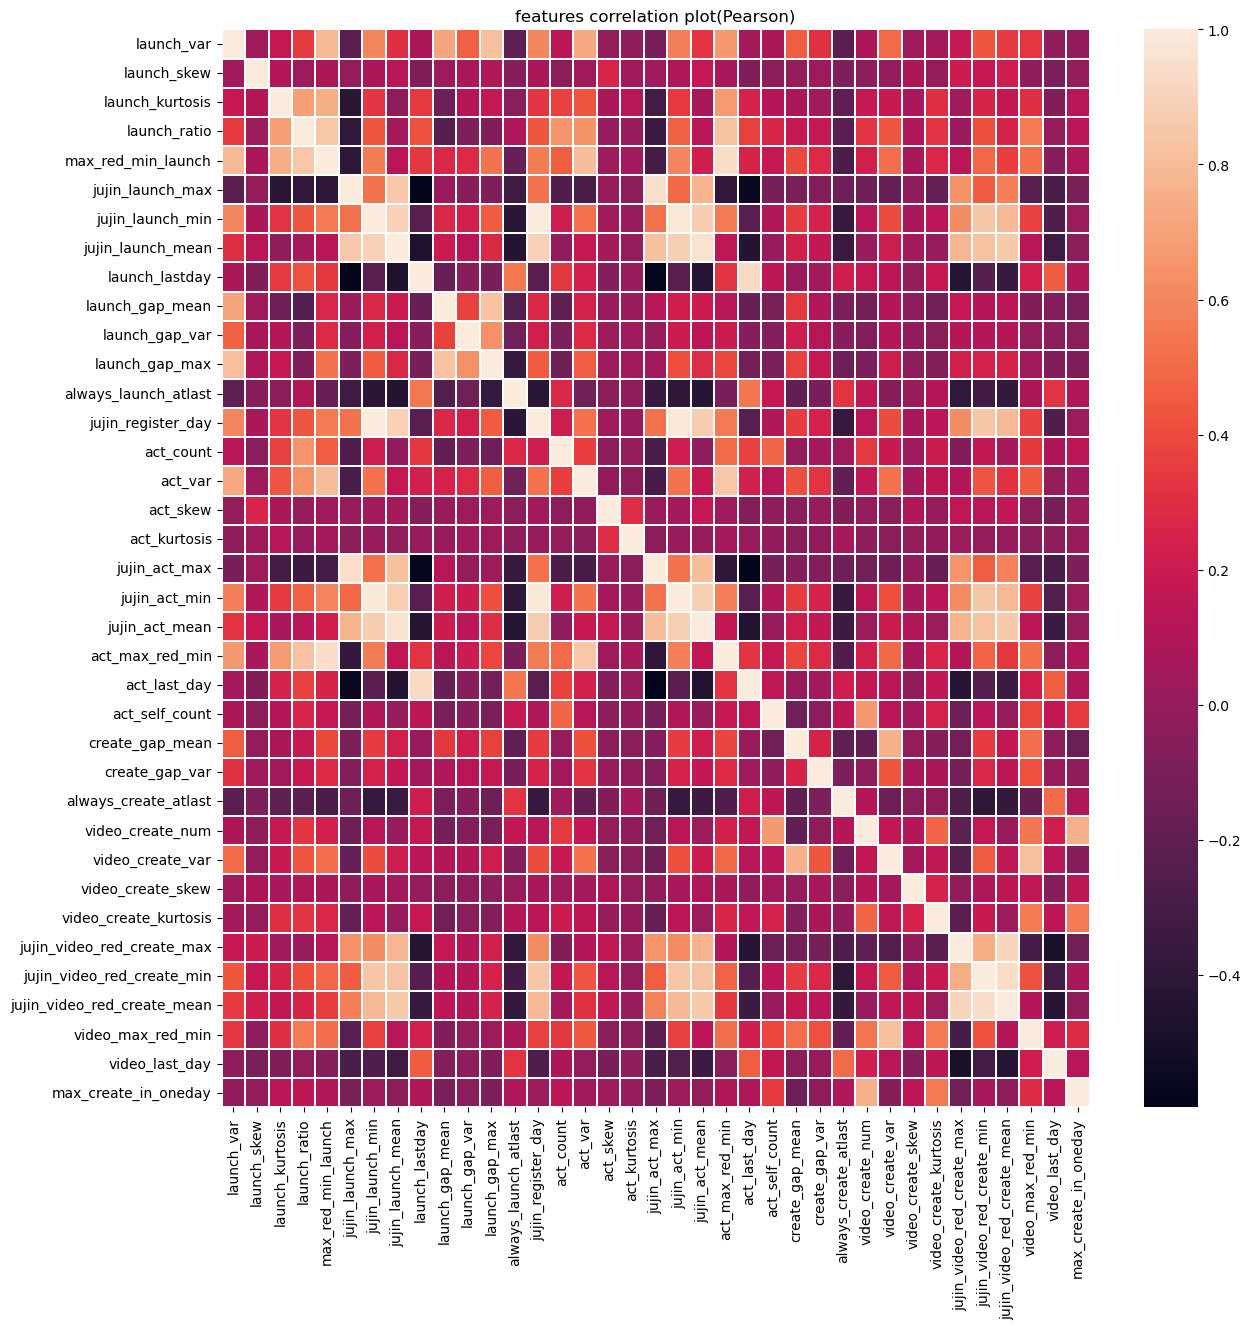

In [17]:
# 查看特征间相关性，排除分类、编码特征
plt.figure(figsize=(14, 14))
plt.title('features correlation plot(Pearson)')
# data_feature = data_l[3][[col for col in data_l[3].columns if col not in ['user_id', 'label']]]
data_feature = data_l[3][['launch_var', 'launch_skew', 'launch_kurtosis',
                          'launch_ratio', 'max_red_min_launch', 'jujin_launch_max',
                          'jujin_launch_min', 'jujin_launch_mean', 'launch_lastday',
                          'launch_gap_mean', 'launch_gap_var', 'launch_gap_max',
                          'always_launch_atlast', 'jujin_register_day', 'act_count',
                          'act_var', 'act_skew', 'act_kurtosis', 'jujin_act_max', 'jujin_act_min',
                          'jujin_act_mean', 'act_max_red_min', 'act_last_day', 'act_self_count',
                          'create_gap_mean', 'create_gap_var',
                          'always_create_atlast', 'video_create_num', 'video_create_var',
                          'video_create_skew', 'video_create_kurtosis',
                          'jujin_video_red_create_max', 'jujin_video_red_create_min',
                          'jujin_video_red_create_mean', 'video_max_red_min', 'video_last_day',
                          'max_create_in_oneday']]
data_corr = data_feature.corr()
sns.heatmap(data_corr, xticklabels=data_corr.columns, yticklabels=data_corr.columns, linewidths=.1)
plt.show()

In [18]:
# 特征筛选  由于数据缺失值过多，采用方差选择法筛选出特征
from sklearn import feature_selection
var = feature_selection.VarianceThreshold()
features_var = var.fit_transform(data_l[3][[col for col in data_l[3].columns if col not in ['user_id', 'label']]])
var_columns = var.get_feature_names_out()

In [19]:
var_columns

array(['launch_var', 'launch_skew', 'launch_kurtosis', 'launch_ratio',
       'max_red_min_launch', 'jujin_launch_max', 'jujin_launch_min',
       'jujin_launch_mean', 'launch_lastday', 'launch_gap_mean',
       'launch_gap_var', 'launch_gap_max', 'always_launch_atlast',
       'jujin_register_day', 'register_type_1', 'register_type_10',
       'register_type_11', 'register_type_2', 'register_type_3',
       'register_type_4', 'register_type_5', 'register_type_6',
       'register_type_7', 'register_type_8', 'register_type_9',
       'device_type_0', 'device_type_1', 'device_type_2', 'device_type_3',
       'device_type_7', 'device_type_8', 'device_type_9', 'act_count',
       'act_var', 'act_skew', 'act_kurtosis', 'jujin_act_max',
       'jujin_act_min', 'jujin_act_mean', 'act_max_red_min',
       'act_last_day', 'act_self_count', 'action_0_count',
       'action_1_count', 'action_2_count', 'action_3_count',
       'action_4_count', 'action_5_count', 'action_all', 'action_0_ratio',
  

### 训练模型

In [20]:
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

### 模型融合

In [21]:
from mlxtend.classifier import EnsembleVoteClassifier

In [22]:
clf1 = XGBClassifier(n_jobs=-1, max_depth=4, min_child_weight=10,
                     subample=0.1, colsample_bytree=0.9, gamma=1e-6,
                     learning_rate=0.2, n_estimators=30)
clf2 = LGBMClassifier(n_jobs=-1, boosting_type='gbdt', learning_rate=0.025, n_estimators=105,
                      max_depth=10, num_leaves=32, max_bin=40, min_data_in_leaf=10, feature_fraction=0.2,
                      bagging_freq=10, bagging_fraction=0.1, lambda_l1=0.1, lambda_l2=0.1,
                      min_split_gain=0.5)
clf3 = CatBoostClassifier(iterations=310, learning_rate=0.01, od_type='IncToDec', depth=9, l2_leaf_reg=0.1,
                          grow_policy='Depthwise', border_count=270)

eclf = EnsembleVoteClassifier(clfs=[clf1, clf2, clf3], voting='soft')
eclf.fit(data_l[2][var_columns], data_l[2]['label'])

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
0:	learn: 0.6859020	total: 124ms	remaining: 38.2s
1:	learn: 0.6790578	total: 186ms	remaining: 28.7s
2:	learn: 0.6724551	total: 230ms	remaining: 23.6s
3:	learn: 0.6661281	total: 279ms	remaining: 21.3s
4:	learn: 0.6601121	total: 323ms	remaining: 19.7s
5:	learn: 0.6540860	total: 373ms	remaining: 18.9s
6:	learn: 0.6483036	

149:	learn: 0.4028823	total: 6.88s	remaining: 7.34s
150:	learn: 0.4024917	total: 6.92s	remaining: 7.29s
151:	learn: 0.4020914	total: 6.98s	remaining: 7.25s
152:	learn: 0.4016852	total: 7.03s	remaining: 7.21s
153:	learn: 0.4012769	total: 7.07s	remaining: 7.16s
154:	learn: 0.4008999	total: 7.13s	remaining: 7.13s
155:	learn: 0.4005177	total: 7.17s	remaining: 7.08s
156:	learn: 0.4001285	total: 7.22s	remaining: 7.03s
157:	learn: 0.3997992	total: 7.26s	remaining: 6.98s
158:	learn: 0.3994567	total: 7.3s	remaining: 6.93s
159:	learn: 0.3990311	total: 7.36s	remaining: 6.89s
160:	learn: 0.3986533	total: 7.4s	remaining: 6.85s
161:	learn: 0.3983386	total: 7.44s	remaining: 6.8s
162:	learn: 0.3980077	total: 7.49s	remaining: 6.75s
163:	learn: 0.3976764	total: 7.53s	remaining: 6.7s
164:	learn: 0.3972714	total: 7.59s	remaining: 6.67s
165:	learn: 0.3968910	total: 7.64s	remaining: 6.63s
166:	learn: 0.3965414	total: 7.69s	remaining: 6.58s
167:	learn: 0.3961875	total: 7.73s	remaining: 6.53s
168:	learn: 0.39

EnsembleVoteClassifier(clfs=[XGBClassifier(colsample_bytree=0.9, gamma=1e-06,
                                           learning_rate=0.2, max_depth=4,
                                           min_child_weight=10, n_estimators=30,
                                           n_jobs=-1, subample=0.1),
                             LGBMClassifier(bagging_fraction=0.1,
                                            bagging_freq=10,
                                            feature_fraction=0.2, lambda_l1=0.1,
                                            lambda_l2=0.1, learning_rate=0.025,
                                            max_bin=40, max_depth=10,
                                            min_data_in_leaf=10,
                                            min_split_gain=0.5,
                                            n_estimators=105, num_leaves=32),
                       voting='soft')

In [23]:
from sklearn.metrics import plot_roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, \
    classification_report

In [24]:
def plot_PR_curve(classifier, X_test, y_test):
    y_score = classifier.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    fig, ax = plt.subplots()
    ax.plot(recall, precision, color='purple')
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    plt.show()


def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, cmap='Blues', fmt='')


def model_evaluation(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    plot_confusion_matrix(y_test, y_pred)
    print('ROC_AUC_SCORE: ', roc_auc_score(y_test, y_pred))
    report = classification_report(y_test, y_pred)
    print(report)
    plot_roc_curve(classifier, X_test, y_test)
    plot_PR_curve(classifier, X_test, y_test)

ROC_AUC_SCORE:  0.8172200375934122
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     19233
           1       0.82      0.81      0.81     18213

    accuracy                           0.82     37446
   macro avg       0.82      0.82      0.82     37446
weighted avg       0.82      0.82      0.82     37446



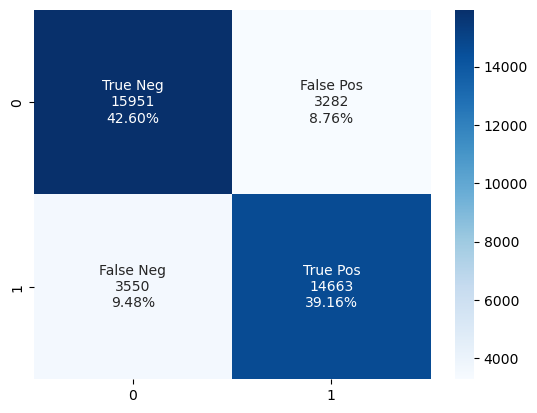

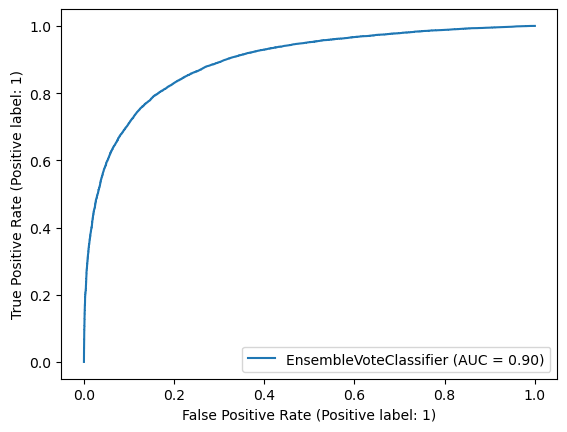

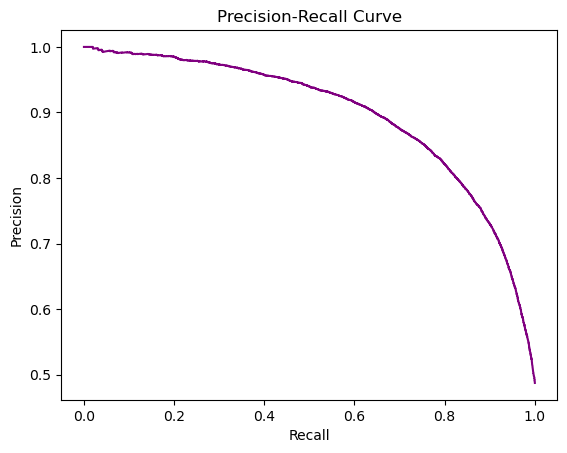

In [25]:
model_evaluation(eclf,data_l[3][var_columns], data_l[3]['label'])

  模型准确率召回率均达到0.8,效果较好，可作为base model 继续调优